In [1]:
# Data managing
import glob
import pickle
import tqdm
import pandas as pd

# Data augmentation
# import albumentations

# Computations
import numpy as np
import torch
import torch.nn as nn

import torchvision.transforms as transforms

# Image managing and visualization
from cv2 import imread
from IPython.display import Image
import matplotlib.pyplot as plt

## Training data description

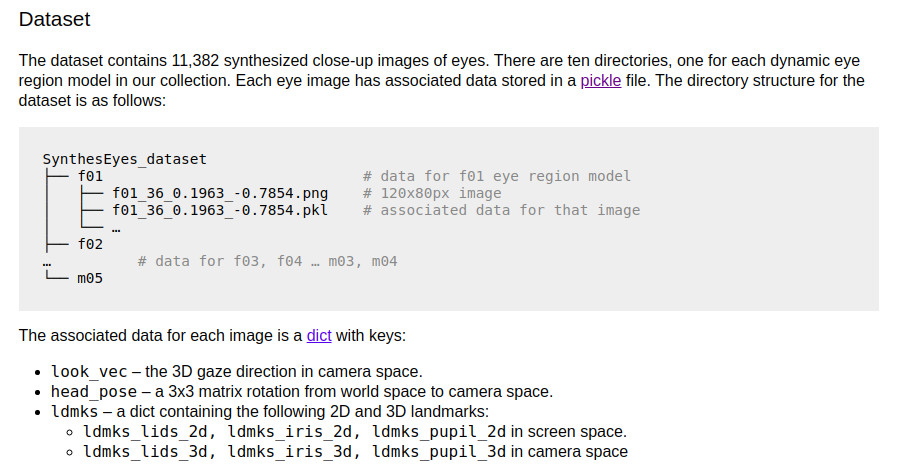

In [12]:
Image('SynthesEyesStruct.jpg')

In [13]:
listed_images = np.array(sorted(glob.glob('**/*.png',recursive=True)))
listed_data = np.array(sorted(glob.glob('**/*.pkl',recursive=True)))
print("images length : {}, data length : {}".format(len(listed_images), len(listed_data)))

images length : 11382, data length : 11382


In [14]:
def get_pickle_dicts(pickle_data):
    look_vec = pickle_data['look_vec']
    head_pose = pickle_data['head_pose']
    ldmks = pickle_data['ldmks']
    return zip(look_vec, head_pose, ldmks)

def get_2d_landmarks(data):
    return zip(data['ldmks_lids_2d'], data['ldmks_iris_2d'], data['ldmks_pupil_2d'])

def get_3d_landmarks(data):
    return zip(data['ldmks_lids_3d'], data['ldmks_iris_3d'], data['ldmks_pupil_3d'])

## Training data visualization

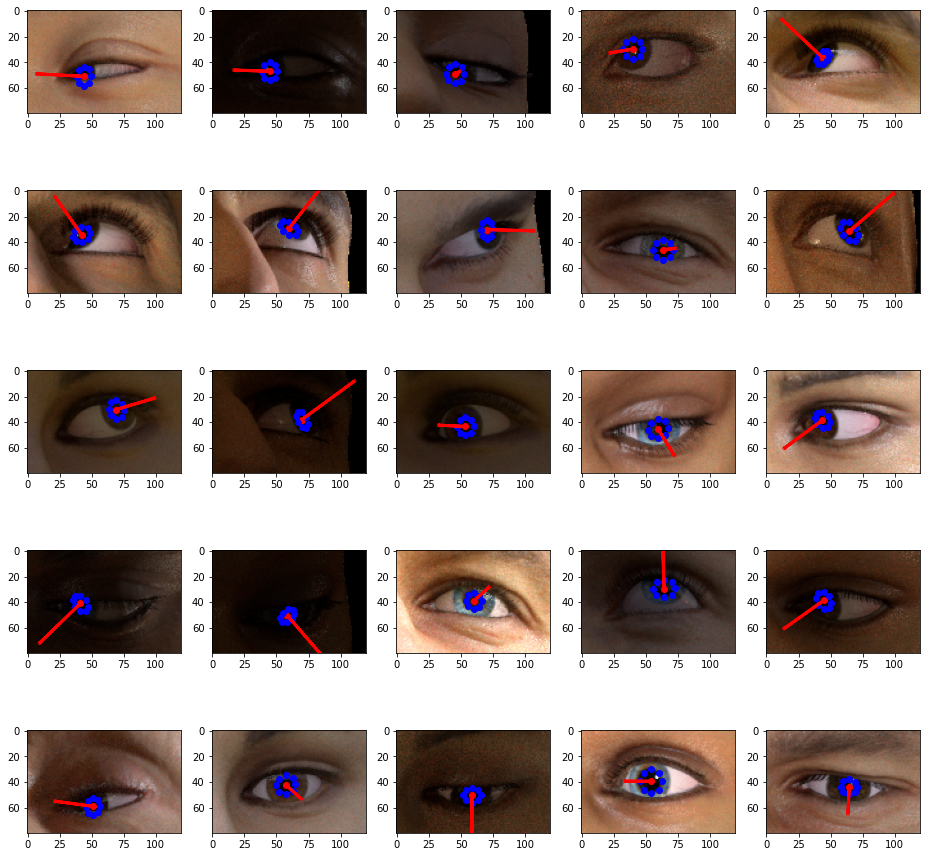

In [15]:
import random

def visualize_gaze(ax, reference_point, gaze_vector, eulers=False, length = 50, color='red'):
    if not eulers:
        x, y, z = gaze_vector
        yaw = np.arctan2(x, z)
        pitch = np.arctan2(y, z)
    else:
        yaw, pitch = gaze_vector
    dx = np.rint(length * np.sin(yaw))
    dy = np.rint(length * np.sin(pitch))
    ax.arrow(reference_point[0], reference_point[1], dx, dy, color=color, lw=3) 

def inspect_image(index, ax):
    sample_image = listed_images[index]
    sample_data = listed_data[index]
    
    image = imread(sample_image)
    image = image[:, :, [2, 1, 0]]
    data = None
    with open(sample_data, 'rb') as file:
        data = pickle.load(file)
    
    ax.imshow(image)
    pupil_landmarks = data['ldmks']['ldmks_pupil_2d']
    pupil_center = np.mean(pupil_landmarks, axis=0)
    
    visualize_gaze(ax, pupil_center, data['look_vec'])
    ax.scatter(pupil_center[0], pupil_center[1], color='red')
    ax.scatter(list(map(lambda x : x[0], pupil_landmarks)), list(map(lambda x : x[1], pupil_landmarks)), color = 'blue')

N, M = 5, 5

indexes = [random.randint(0, len(listed_images) - 1) for _ in range(N * M)]
fig, ax = plt.subplots(nrows=N, ncols=M, figsize=(16, 16))
for index, image in enumerate(indexes):
    inspect_image(image, ax[index // N, index % M])
plt.show()

## Pytorch map-style Dataset 

In [16]:
# Lets first try gaze-only dataset (w/o pupil center, for example)

def vector_to_angles(gaze_vector):
    """ 
    Input : gaze vector in camera coordinate system
    
    Returns :  yaw and pitch in camera coordinate system"""
    x, y, z = gaze_vector

    yaw = np.arctan2(x, z)
    pitch = np.arctan2(y, z)
    return yaw, pitch

class GazeOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, pickles_path):
        self.size = len(images_path)
        # Store images in pytorch-like shape
        image_shape = (3, 80, 120) 
        
        self.images = np.empty((self.size, *(image_shape)), dtype=np.float32)
        self.gazes = np.empty((self.size, 2), dtype=np.float32)
        self.pupil_centers = np.empty((self.size, 2), dtype=np.int)
        
        pickle_data = None
        for index, (image_path, data_path) in tqdm.tqdm(enumerate(zip(images_path, pickles_path))):
            with open(data_path, 'rb') as file:
                pickle_data = pickle.load(file)
            # Swap channels since opev-cv loads everything in BGR format scale it as well, becuase 
            # images values have 'uint8' type
            self.images[index] = imread(image_path)[:, :, [2, 1, 0]].transpose(2, 0, 1) / 255
            self.gazes[index] = vector_to_angles(pickle_data['look_vec'])
            self.pupil_centers[index] = np.round(np.mean(pickle_data['ldmks']['ldmks_pupil_2d'], axis=0))
            
    def __getitem__(self, index):
        return (self.images[index], self.gazes[index], self.pupil_centers[index]) 
        
    def __len__(self):
        return self.size

## Pytorch Dataloader for training the neural network

In [17]:
def create_loader(images_path, pickles_path, 
                  batch_size = 32,
                  split_ratio = 0.9,
                  num_workers= 0,
                  pin_memory= False):
    size = len(images_path)
    assert size == len(pickles_path), \
    "Length of images {} doens't match associated data length {}".format(size, len(pickles_path))
    
    assert (split_ratio >= 0 and split_ratio < 1), "Split ration must lay in range of [0, 1)"
    
    right_border = np.int(split_ratio * size)
    
    train_images_path = images_path[: right_border]
    train_pickles_path = pickles_path[: right_border]
    
    test_images_path = images_path[right_border : ]
    test_pickles_path = pickles_path[right_border : ]
    
    train_data = GazeOnlyDataset(train_images_path, train_pickles_path)
    test_data = GazeOnlyDataset(test_images_path, test_pickles_path)
    
    train_loader = torch.utils.data.DataLoader(
        train_data,
        shuffle=True,
        batch_size=batch_size,
        num_workers=0,
        drop_last=True,
        pin_memory=pin_memory
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_data,
        shuffle=False,
        batch_size=batch_size,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=pin_memory
    )
    return train_loader, test_loader

In [18]:
train_loader, test_loader = create_loader(listed_images, listed_data)

10243it [05:13, 32.63it/s]
1139it [00:33, 34.13it/s]


## GazeNet

This simple model which is inspired by architecture of neural net designed for pupil localization from 
NVidia NVGaze paper at

(CHI'19 : ACM CHI Conference on Human Factors in Computing Systems)

In [42]:
def init_weights(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
    elif isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
        
class GazeNet(nn.Module):
    def __init__(self):
        super(GazeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=[9, 9], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=36, kernel_size=[7, 7], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=36, out_channels=52, kernel_size=[5, 5], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=52, out_channels=80, kernel_size=[5, 5], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.conv5= nn.Sequential(
            nn.Conv2d(in_channels=80, out_channels=124, kernel_size=[3, 3], stride =[1, 1], padding=[1, 1]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=124, out_channels=256, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.dense1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4, 1024),
            nn.Dropout(0.5)
        )
        self.dense2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 2)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)        
        x = self.conv6(x)
        x = self.conv7(x)
        
        x = self.dense1(x)
        x = self.dense2(x)
        return x

### Setup device

It's either CPU or single GPU

In [43]:
use_gpu = False
device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"

print("Working device : ", end='')
if device == "cuda":
    print("GPU - {}".format(torch.cuda.get_device_name(0)))
    !nvidia-smi
else:
    print("CPU")

Working device : CPU


## Check forward pass time

In [44]:
model = GazeNet()
model.apply(init_weights)
model.to(device)

GazeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=[9, 9], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(24, 36, kernel_size=[7, 7], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(36, 52, kernel_size=[5, 5], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(52, 80, kernel_size=[5, 5], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(80, 124, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(124, 256, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv7): Sequential(
    (0): Conv2d(256, 512, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
    (1): Dr

In [45]:
%%time
dummy = torch.rand(1, 3, 120, 80).to(device)
print(model(dummy).shape)

torch.Size([1, 2])
Wall time: 51 ms


In [46]:
state_dict = model.state_dict()
torch.save(state_dict, "models/2dense_size_test.pth")

### Average meter
Little utility class that helps to track loss progress in real time

In [51]:
class AverageMeter():
    def __init__(self):
        self.reset()
    def reset(self):
        self.count = 0
        self.average = 0
        self.sum = 0
        self.val = 0
    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

In [52]:
def train(epoch, train_loader, model, optimizer, criterion, meter, train_history):
    model.train()
    model.to(device)
    
    train_size = len(train_loader)
    # For now we don't need pupil center for training
    for step, (images, gazes, _) in enumerate(iter(train_loader)):
        optimizer.zero_grad()
        
        images.to(device)
        gazes.to(device)
        
        predictions = model(images)
        loss = criterion(predictions, gazes)
        loss.backward()
        
        optimizer.step()
        
        size = images.size(0)
        meter.update(loss.item(), size)
        
        if step % 25 == 0:
            print("Epoch : {} ({}/{}), loss : {:.2f} ({})".format(epoch, step, train_size, meter.val, meter.avg))
    # Train will consist of tuples (epoch, current_average_error) for further plotting
    train_history.append((epoch, meter.avg))

In [53]:
# Draw and save evaluation on test set
def draw_results(ax, image, pupil_center, gaze, prediction):
    ax.imshow(image)
    visualize_gaze(ax, pupil_center, gaze, eulers=True, color='red')
    visualize_gaze(ax, pupil_center, prediction, eulers=True, color='blue')

def test_and_save(test_loader, model, criterion, skip=1):
    model.eval()
    
    average_meter = AverageMeter()
    with torch.no_grad():
        for step, (images, gazes, pupil_centers) in tqdm.tqdm(enumerate(test_loader)):
            predictions = model(images)
            loss = criterion(predictions, gazes)
            
            size = images.size(0)
            average_meter.update(loss.item(), size)
            
            images = images[:25]
            gazes = gazes[:25]
            pupil_centers = pupil_centers[:25]
            predictions = model(images)
            
            N, M = 5, 5
            fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(18, 18))
            for index, (image, gaze, prediction, pupil_center) in enumerate(zip(images, gazes, predictions, pupil_centers)):
                # Since image is torch.tensor now, it's shape (C, H, W)
                draw_results(ax[index // N, index % M], image.permute(1, 2, 0), pupil_center, gaze, prediction)
            plt.savefig("predictions/gazes_predictions_{}.jpg".format(step))
            plt.close(fig)
    print("Test size : {}\nTest loss : {}".format(average_meter.count, average_meter.avg))

In [71]:
def test(epoch, test_loader, model, criterion, test_history):
    model.eval()
    
    average_meter = AverageMeter()
    with torch.no_grad():
        for images, gazes, _ in tqdm.tqdm(test_loader):
            predictions = model(images)
            loss = criterion(predictions, gazes)
            
            size = images.size(0)
            average_meter.update(loss.item(), size)
    test_history.append((epoch, average_meter.avg))
    print("Test size : {}".format(average_meter.count))
    print("Test loss : {:.2f}".format(average_meter.avg))

In [57]:
train_history = []
test_history = []
    
def main():
    model = GazeNet()
    model.to(device)
    model.apply(init_weights)
    # Parameters that are used here has same value
    # as in NVidia paper (except for amount of epochs and scheduler
    # because we use different dataset)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-4,
        betas=[0.9, 0.99],
        eps=1e-8
    )
    criterion = torch.nn.L1Loss(reduction='mean')
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[140],
        gamma=1e-3
    )
    
    epochs = 150
    meter = AverageMeter()
    for epoch in range(1, epochs + 1):
        train(epoch, train_loader, model, optimizer, criterion, meter, train_history)
        
        # Dirty hack to make tqdm work correctly
        print("Evaluating model on test set...")
        scheduler.step()
        
        test(epoch, test_loader, model, criterion, test_history)
        print("Epoch {} ended, train loss : {:.2f}".format(epoch, meter.avg))
        
        if epoch % 15 == 0:
            print("Saving the model...")
            state_dict = model.state_dict()
            torch.save(state_dict, "models/model_state_{}.pth".format(epoch))
            print("Saved successfully")
        
    print("Training ended")

In [58]:
main()

Epoch : 1 (0/320), loss : 2.85 (2.8517258167266846)
Epoch : 1 (25/320), loss : 2.58 (2.7296381913698635)
Epoch : 1 (50/320), loss : 2.76 (2.6879519528033686)
Epoch : 1 (75/320), loss : 2.29 (2.6364934569910954)
Epoch : 1 (100/320), loss : 2.29 (2.5630631659290577)
Epoch : 1 (125/320), loss : 2.33 (2.502709610121591)
Epoch : 1 (150/320), loss : 2.10 (2.448324389015602)
Epoch : 1 (175/320), loss : 1.97 (2.3981863619251684)
Epoch : 1 (200/320), loss : 2.12 (2.365087724443692)
Epoch : 1 (225/320), loss : 1.86 (2.3373478687969986)
Epoch : 1 (250/320), loss : 2.16 (2.3103313379553683)
Epoch : 1 (275/320), loss : 2.04 (2.282951579577681)
Epoch : 1 (300/320), loss : 1.95 (2.2596113772883366)


  1%|▊                                                                                 | 3/320 [00:00<00:15, 21.13it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:15<00:00, 20.73it/s]


Test loss : 1.928159312903881
Epoch 1 ended, train loss : 2.2438857536762953
Saving the model...
Saved successfully
Epoch : 2 (0/320), loss : 2.08 (2.2433874291422953)
Epoch : 2 (25/320), loss : 1.80 (2.215962125386806)
Epoch : 2 (50/320), loss : 1.94 (2.19655969811257)
Epoch : 2 (75/320), loss : 2.04 (2.177043922922828)
Epoch : 2 (100/320), loss : 1.79 (2.1606488743190813)
Epoch : 2 (125/320), loss : 1.70 (2.145694456025624)
Epoch : 2 (150/320), loss : 1.66 (2.1255093605401916)
Epoch : 2 (175/320), loss : 1.63 (2.112002098271924)
Epoch : 2 (200/320), loss : 1.57 (2.093558702496329)
Epoch : 2 (225/320), loss : 1.67 (2.078237388596867)
Epoch : 2 (250/320), loss : 1.99 (2.0613543797290887)
Epoch : 2 (275/320), loss : 1.92 (2.0475580398268347)
Epoch : 2 (300/320), loss : 1.52 (2.0330750713793746)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.43it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 13.91it/s]


Test loss : 1.5279004577547313
Epoch 2 ended, train loss : 2.0230350982397796
Saving the model...
Saved successfully
Epoch : 3 (0/320), loss : 1.61 (2.0223936497142274)
Epoch : 3 (25/320), loss : 1.55 (2.0084574031042264)
Epoch : 3 (50/320), loss : 1.70 (1.993166068010841)
Epoch : 3 (75/320), loss : 1.79 (1.9805436570551143)
Epoch : 3 (100/320), loss : 1.60 (1.967236366188317)
Epoch : 3 (125/320), loss : 1.08 (1.954011293210809)
Epoch : 3 (150/320), loss : 1.48 (1.9390954849240754)
Epoch : 3 (175/320), loss : 1.59 (1.9269838096464382)
Epoch : 3 (200/320), loss : 1.80 (1.9147867225154827)
Epoch : 3 (225/320), loss : 1.35 (1.902500511317)
Epoch : 3 (250/320), loss : 1.41 (1.8896251899492327)
Epoch : 3 (275/320), loss : 1.35 (1.8750059992465389)
Epoch : 3 (300/320), loss : 1.25 (1.862076240378916)


  1%|▌                                                                                 | 2/320 [00:00<00:28, 11.21it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.37it/s]


Test loss : 1.2171729447320103
Epoch 3 ended, train loss : 1.8532075306400657
Saving the model...
Saved successfully
Epoch : 4 (0/320), loss : 1.55 (1.852893717765312)
Epoch : 4 (25/320), loss : 0.97 (1.8407065694883435)
Epoch : 4 (50/320), loss : 1.13 (1.8276553009549188)
Epoch : 4 (75/320), loss : 1.40 (1.8164199175866875)
Epoch : 4 (100/320), loss : 1.56 (1.8051761844380636)
Epoch : 4 (125/320), loss : 1.03 (1.793228551004473)
Epoch : 4 (150/320), loss : 1.58 (1.7817584763873706)
Epoch : 4 (175/320), loss : 0.95 (1.7695630328651046)
Epoch : 4 (200/320), loss : 1.09 (1.758683722199909)
Epoch : 4 (225/320), loss : 1.01 (1.7468958068356346)
Epoch : 4 (250/320), loss : 1.34 (1.7358640199058022)
Epoch : 4 (275/320), loss : 1.13 (1.7246670681488938)
Epoch : 4 (300/320), loss : 1.05 (1.7140155670947257)


  1%|▊                                                                                 | 3/320 [00:00<00:15, 20.83it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.44it/s]


Test loss : 0.9878475363366306
Epoch 4 ended, train loss : 1.7045510599855334
Saving the model...
Saved successfully
Epoch : 5 (0/320), loss : 0.99 (1.7039926312660258)
Epoch : 5 (25/320), loss : 1.27 (1.693613811528701)
Epoch : 5 (50/320), loss : 0.96 (1.6827558458164882)
Epoch : 5 (75/320), loss : 0.83 (1.6723651133016146)
Epoch : 5 (100/320), loss : 0.87 (1.66271243412196)
Epoch : 5 (125/320), loss : 1.00 (1.6531679853267045)
Epoch : 5 (150/320), loss : 1.09 (1.6433659167159778)
Epoch : 5 (175/320), loss : 0.95 (1.6336872835162577)
Epoch : 5 (200/320), loss : 0.94 (1.6243018507152533)
Epoch : 5 (225/320), loss : 1.43 (1.6142529532570604)
Epoch : 5 (250/320), loss : 0.91 (1.6046069417024733)
Epoch : 5 (275/320), loss : 0.95 (1.5961330777422016)
Epoch : 5 (300/320), loss : 0.96 (1.5871476084653673)


  0%|▎                                                                                 | 1/320 [00:00<00:43,  7.41it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.32it/s]


Test loss : 0.9290381822735071
Epoch 5 ended, train loss : 1.5813022715225815
Saving the model...
Saved successfully
Epoch : 6 (0/320), loss : 1.24 (1.581088144841751)
Epoch : 6 (25/320), loss : 0.90 (1.5719777345657349)
Epoch : 6 (50/320), loss : 1.04 (1.5631007228130143)
Epoch : 6 (75/320), loss : 0.98 (1.5550886837316584)
Epoch : 6 (100/320), loss : 0.96 (1.5467710201877625)
Epoch : 6 (125/320), loss : 0.71 (1.5380222379712352)
Epoch : 6 (150/320), loss : 0.74 (1.5299010909434252)
Epoch : 6 (175/320), loss : 1.11 (1.52260548247209)
Epoch : 6 (200/320), loss : 1.13 (1.5149755625675811)
Epoch : 6 (225/320), loss : 0.94 (1.506847669838684)
Epoch : 6 (250/320), loss : 1.00 (1.49884809085899)
Epoch : 6 (275/320), loss : 1.02 (1.4915549667246306)
Epoch : 6 (300/320), loss : 1.12 (1.483892156270728)


  1%|▌                                                                                 | 2/320 [00:00<00:25, 12.58it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.15it/s]


Test loss : 0.7724862466566265
Epoch 6 ended, train loss : 1.4786426774070909
Saving the model...
Saved successfully
Epoch : 7 (0/320), loss : 1.05 (1.4784174000981076)
Epoch : 7 (25/320), loss : 0.79 (1.4711091317626948)
Epoch : 7 (50/320), loss : 0.85 (1.4635755802428643)
Epoch : 7 (75/320), loss : 0.83 (1.4570203618349915)
Epoch : 7 (100/320), loss : 0.87 (1.4496291227443332)
Epoch : 7 (125/320), loss : 1.15 (1.4425362064371128)
Epoch : 7 (150/320), loss : 0.99 (1.4356429816472362)
Epoch : 7 (175/320), loss : 0.70 (1.4291622703966067)
Epoch : 7 (200/320), loss : 1.06 (1.4230404916179455)
Epoch : 7 (225/320), loss : 0.62 (1.4163029880331481)
Epoch : 7 (250/320), loss : 0.66 (1.4097197707733873)
Epoch : 7 (275/320), loss : 1.01 (1.4032302404497707)
Epoch : 7 (300/320), loss : 0.81 (1.39727226822884)


  1%|▌                                                                                 | 2/320 [00:00<00:25, 12.42it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.08it/s]


Test loss : 0.6734854991547763
Epoch 7 ended, train loss : 1.393182798647987
Saving the model...
Saved successfully
Epoch : 8 (0/320), loss : 0.89 (1.39295782569741)
Epoch : 8 (25/320), loss : 0.66 (1.3872284933806307)
Epoch : 8 (50/320), loss : 0.67 (1.3804584537099824)
Epoch : 8 (75/320), loss : 0.96 (1.3746814841407775)
Epoch : 8 (100/320), loss : 0.60 (1.3683752621126604)
Epoch : 8 (125/320), loss : 0.75 (1.3626381155427794)
Epoch : 8 (150/320), loss : 0.90 (1.3576376483635841)
Epoch : 8 (175/320), loss : 0.98 (1.3519556872571343)
Epoch : 8 (200/320), loss : 0.64 (1.3457766046464468)
Epoch : 8 (225/320), loss : 0.86 (1.3403249609088472)
Epoch : 8 (250/320), loss : 0.89 (1.334438199273844)
Epoch : 8 (275/320), loss : 0.62 (1.3286137455076406)
Epoch : 8 (300/320), loss : 0.81 (1.3234767367970235)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 12.11it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.10it/s]


Test loss : 0.5874637917149812
Epoch 8 ended, train loss : 1.3192203239537776
Saving the model...
Saved successfully
Epoch : 9 (0/320), loss : 0.79 (1.3190139279101147)
Epoch : 9 (25/320), loss : 0.56 (1.3131658576388554)
Epoch : 9 (50/320), loss : 0.89 (1.3080330385599315)
Epoch : 9 (75/320), loss : 0.73 (1.3025261683895484)
Epoch : 9 (100/320), loss : 0.51 (1.2967898690893165)
Epoch : 9 (125/320), loss : 0.62 (1.2914742190870703)
Epoch : 9 (150/320), loss : 0.74 (1.2862102611506394)
Epoch : 9 (175/320), loss : 0.69 (1.2811602364833419)
Epoch : 9 (200/320), loss : 0.70 (1.2762825080598017)
Epoch : 9 (225/320), loss : 0.92 (1.2721089086062773)
Epoch : 9 (250/320), loss : 0.73 (1.2674382801307813)
Epoch : 9 (275/320), loss : 0.61 (1.2627589034050577)
Epoch : 9 (300/320), loss : 0.58 (1.2580987305147004)


  0%|▎                                                                                 | 1/320 [00:00<00:31, 10.00it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.01it/s]


Test loss : 0.5280219449661672
Epoch 9 ended, train loss : 1.2544638553427325
Saving the model...
Saved successfully
Epoch : 10 (0/320), loss : 0.60 (1.2542354665213018)
Epoch : 10 (25/320), loss : 0.86 (1.2491865144236205)
Epoch : 10 (50/320), loss : 0.60 (1.2446237869207382)
Epoch : 10 (75/320), loss : 0.72 (1.2398095734326702)
Epoch : 10 (100/320), loss : 0.52 (1.2349454288073172)
Epoch : 10 (125/320), loss : 0.62 (1.2305068438618643)
Epoch : 10 (150/320), loss : 0.75 (1.2263256583383713)
Epoch : 10 (175/320), loss : 0.65 (1.2219454152850893)
Epoch : 10 (200/320), loss : 1.17 (1.2176933328426724)
Epoch : 10 (225/320), loss : 0.53 (1.2138759247905888)
Epoch : 10 (250/320), loss : 1.06 (1.2101587026749736)
Epoch : 10 (275/320), loss : 0.59 (1.2057856613125637)
Epoch : 10 (300/320), loss : 0.49 (1.2014399171625059)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.49it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.71it/s]


Test loss : 0.4606854856014252
Epoch 10 ended, train loss : 1.1983758088573813
Saving the model...
Saved successfully
Epoch : 11 (0/320), loss : 0.76 (1.1982403483587443)
Epoch : 11 (25/320), loss : 0.76 (1.1940210691739221)
Epoch : 11 (50/320), loss : 0.60 (1.1897689295856448)
Epoch : 11 (75/320), loss : 0.53 (1.1857041529264933)
Epoch : 11 (100/320), loss : 0.67 (1.1822533930604728)
Epoch : 11 (125/320), loss : 0.59 (1.1784459544066843)
Epoch : 11 (150/320), loss : 0.68 (1.1744259587866768)
Epoch : 11 (175/320), loss : 0.57 (1.1705237448091896)
Epoch : 11 (200/320), loss : 0.60 (1.1669328955736835)
Epoch : 11 (225/320), loss : 0.74 (1.1629825804623957)
Epoch : 11 (250/320), loss : 0.48 (1.1592870370974164)
Epoch : 11 (275/320), loss : 0.52 (1.1555738424747257)
Epoch : 11 (300/320), loss : 0.45 (1.1520851358996906)


  1%|▊                                                                                 | 3/320 [00:00<00:14, 22.06it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 12.25it/s]


Test loss : 0.4395377816166729
Epoch 11 ended, train loss : 1.1495570802468469
Saving the model...
Saved successfully
Epoch : 12 (0/320), loss : 0.59 (1.1493994994737045)
Epoch : 12 (25/320), loss : 0.53 (1.1453402367054375)
Epoch : 12 (50/320), loss : 0.71 (1.1418311787366)
Epoch : 12 (75/320), loss : 0.36 (1.1381808309769206)
Epoch : 12 (100/320), loss : 0.50 (1.134528442785181)
Epoch : 12 (125/320), loss : 0.37 (1.1310529427840954)
Epoch : 12 (150/320), loss : 0.79 (1.1277141235921013)
Epoch : 12 (175/320), loss : 0.70 (1.1242072995010264)
Epoch : 12 (200/320), loss : 0.48 (1.120586260844866)
Epoch : 12 (225/320), loss : 0.83 (1.1173944372228295)
Epoch : 12 (250/320), loss : 0.48 (1.113822652897826)
Epoch : 12 (275/320), loss : 0.60 (1.1105321804483521)
Epoch : 12 (300/320), loss : 0.89 (1.1076097947644552)


  1%|▊                                                                                 | 3/320 [00:00<00:14, 22.24it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.21it/s]


Test loss : 0.4245644814800471
Epoch 12 ended, train loss : 1.1049175555740172
Saving the model...
Saved successfully
Epoch : 13 (0/320), loss : 0.73 (1.1048211155614949)
Epoch : 13 (25/320), loss : 0.68 (1.1015076375167974)
Epoch : 13 (50/320), loss : 0.90 (1.0978755756381606)
Epoch : 13 (75/320), loss : 0.50 (1.0945723975063952)
Epoch : 13 (100/320), loss : 0.57 (1.0913911669561627)
Epoch : 13 (125/320), loss : 0.69 (1.0885008382815275)
Epoch : 13 (150/320), loss : 0.56 (1.0854346856784773)
Epoch : 13 (175/320), loss : 0.67 (1.0824955594967085)
Epoch : 13 (200/320), loss : 0.38 (1.07918418515764)
Epoch : 13 (225/320), loss : 0.70 (1.0765434883523914)
Epoch : 13 (250/320), loss : 0.95 (1.0734277664813747)
Epoch : 13 (275/320), loss : 0.65 (1.0704423900262838)
Epoch : 13 (300/320), loss : 0.45 (1.0677083422382856)


  0%|▎                                                                                 | 1/320 [00:00<00:34,  9.35it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 12.13it/s]


Test loss : 0.4271827993914485
Epoch 13 ended, train loss : 1.0656622412041403
Saving the model...
Saved successfully
Epoch : 14 (0/320), loss : 0.72 (1.0655792683928782)
Epoch : 14 (25/320), loss : 0.49 (1.062969987785708)
Epoch : 14 (50/320), loss : 0.78 (1.0600000218324837)
Epoch : 14 (75/320), loss : 0.85 (1.0571412723986353)
Epoch : 14 (100/320), loss : 0.72 (1.054218360366913)
Epoch : 14 (125/320), loss : 0.60 (1.0515345165134866)
Epoch : 14 (150/320), loss : 0.83 (1.0484733104643593)
Epoch : 14 (175/320), loss : 0.34 (1.0453396379583382)
Epoch : 14 (200/320), loss : 0.40 (1.0424601210452527)
Epoch : 14 (225/320), loss : 0.46 (1.0398264613377957)
Epoch : 14 (250/320), loss : 0.44 (1.036996477543024)
Epoch : 14 (275/320), loss : 0.37 (1.0342184296020578)
Epoch : 14 (300/320), loss : 0.43 (1.031333256802653)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 12.06it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.15it/s]


Test loss : 0.3770412300247699
Epoch 14 ended, train loss : 1.0294159903490383
Saving the model...
Saved successfully
Epoch : 15 (0/320), loss : 0.67 (1.0293357045495917)
Epoch : 15 (25/320), loss : 0.52 (1.0268606134106253)
Epoch : 15 (50/320), loss : 0.56 (1.0242131265043501)
Epoch : 15 (75/320), loss : 0.48 (1.021419667835896)
Epoch : 15 (100/320), loss : 0.27 (1.018627370950229)
Epoch : 15 (125/320), loss : 0.65 (1.016090376123857)
Epoch : 15 (150/320), loss : 0.43 (1.0135879070017204)
Epoch : 15 (175/320), loss : 0.67 (1.0110324485662723)
Epoch : 15 (200/320), loss : 0.55 (1.0084563549023056)
Epoch : 15 (225/320), loss : 0.44 (1.0056850200814234)
Epoch : 15 (250/320), loss : 0.42 (1.0031277914961658)
Epoch : 15 (275/320), loss : 0.52 (1.0005137809999507)
Epoch : 15 (300/320), loss : 0.69 (0.9982838623414252)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.44it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:29<00:00, 10.86it/s]


Test loss : 0.3353359636850655
Epoch 15 ended, train loss : 0.9964204135195662
Saving the model...
Saved successfully
Epoch : 16 (0/320), loss : 0.58 (0.9963340947148055)
Epoch : 16 (25/320), loss : 0.40 (0.993740257016243)
Epoch : 16 (50/320), loss : 0.33 (0.9911889003167765)
Epoch : 16 (75/320), loss : 0.28 (0.9886778229549589)
Epoch : 16 (100/320), loss : 0.40 (0.9863906075390863)
Epoch : 16 (125/320), loss : 0.43 (0.9837187444121916)
Epoch : 16 (150/320), loss : 0.41 (0.9811791463244735)
Epoch : 16 (175/320), loss : 0.43 (0.97890726410128)
Epoch : 16 (200/320), loss : 0.43 (0.9764472293278094)
Epoch : 16 (225/320), loss : 0.38 (0.9741657166350803)
Epoch : 16 (250/320), loss : 0.38 (0.9717589886506887)
Epoch : 16 (275/320), loss : 0.45 (0.9693587681174373)
Epoch : 16 (300/320), loss : 0.33 (0.9672464289032602)


  0%|                                                                                          | 0/320 [00:00<?, ?it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:31<00:00, 10.28it/s]


Test loss : 0.3266430667601526
Epoch 16 ended, train loss : 0.9656614150881069
Saving the model...
Saved successfully
Epoch : 17 (0/320), loss : 0.29 (0.965529161842394)
Epoch : 17 (25/320), loss : 0.57 (0.9631711180733421)
Epoch : 17 (50/320), loss : 0.60 (0.9610816425055099)
Epoch : 17 (75/320), loss : 0.45 (0.9586573126449826)
Epoch : 17 (100/320), loss : 0.31 (0.9562729990983507)
Epoch : 17 (125/320), loss : 0.57 (0.9542093464023186)
Epoch : 17 (150/320), loss : 0.57 (0.9522117031291142)
Epoch : 17 (175/320), loss : 0.51 (0.9500348974508867)
Epoch : 17 (200/320), loss : 0.55 (0.947832919963879)
Epoch : 17 (225/320), loss : 0.56 (0.9457118947977348)
Epoch : 17 (250/320), loss : 0.37 (0.9437611729899857)
Epoch : 17 (275/320), loss : 0.58 (0.941774500104522)
Epoch : 17 (300/320), loss : 0.45 (0.9396459362456728)


  1%|▊                                                                                 | 3/320 [00:00<00:14, 21.75it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.32it/s]


Test loss : 0.3013535016681999
Epoch 17 ended, train loss : 0.93805175665766
Saving the model...
Saved successfully
Epoch : 18 (0/320), loss : 0.46 (0.9379631402715561)
Epoch : 18 (25/320), loss : 0.37 (0.9356939732821224)
Epoch : 18 (50/320), loss : 0.35 (0.9334594708792913)
Epoch : 18 (75/320), loss : 0.53 (0.9312652868365273)
Epoch : 18 (100/320), loss : 0.41 (0.9290211273028175)
Epoch : 18 (125/320), loss : 0.44 (0.9270542726252647)
Epoch : 18 (150/320), loss : 0.58 (0.9249325005910282)
Epoch : 18 (175/320), loss : 0.35 (0.9229400742539017)
Epoch : 18 (200/320), loss : 0.51 (0.9210252288918486)
Epoch : 18 (225/320), loss : 0.56 (0.9192276468761515)
Epoch : 18 (250/320), loss : 0.39 (0.9174507699240451)
Epoch : 18 (275/320), loss : 0.70 (0.9153768973199532)
Epoch : 18 (300/320), loss : 0.75 (0.9135557694668514)


  1%|▌                                                                                 | 2/320 [00:00<00:25, 12.28it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.53it/s]


Test loss : 0.2683016636874527
Epoch 18 ended, train loss : 0.9120948298109902
Saving the model...
Saved successfully
Epoch : 19 (0/320), loss : 0.40 (0.9120059842720687)
Epoch : 19 (25/320), loss : 0.46 (0.9099907555919677)
Epoch : 19 (50/320), loss : 0.52 (0.9079836095195899)
Epoch : 19 (75/320), loss : 0.63 (0.9061087483566987)
Epoch : 19 (100/320), loss : 0.79 (0.9041425494702475)
Epoch : 19 (125/320), loss : 0.35 (0.9022116771779861)
Epoch : 19 (150/320), loss : 0.35 (0.9001689567075448)
Epoch : 19 (175/320), loss : 0.33 (0.8985271806504849)
Epoch : 19 (200/320), loss : 0.34 (0.896637904616015)
Epoch : 19 (225/320), loss : 0.55 (0.8949121632107595)
Epoch : 19 (250/320), loss : 0.41 (0.8929571172641133)
Epoch : 19 (275/320), loss : 0.32 (0.8910735433957014)
Epoch : 19 (300/320), loss : 0.52 (0.8894714887283596)


  1%|▌                                                                                 | 2/320 [00:00<00:28, 11.24it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.00it/s]


Test loss : 0.28650957071222366
Epoch 19 ended, train loss : 0.8881210995078282
Saving the model...
Saved successfully
Epoch : 20 (0/320), loss : 0.39 (0.8880388637114229)
Epoch : 20 (25/320), loss : 0.23 (0.8860777142914327)
Epoch : 20 (50/320), loss : 0.46 (0.884167893078039)
Epoch : 20 (75/320), loss : 0.58 (0.8823697242287942)
Epoch : 20 (100/320), loss : 0.38 (0.8806500445097285)
Epoch : 20 (125/320), loss : 0.26 (0.8787806065542406)
Epoch : 20 (150/320), loss : 0.32 (0.8768628608561542)
Epoch : 20 (175/320), loss : 0.42 (0.8752187145992999)
Epoch : 20 (200/320), loss : 0.34 (0.8734591215459846)
Epoch : 20 (225/320), loss : 0.35 (0.8717689872794668)
Epoch : 20 (250/320), loss : 0.23 (0.870029934168408)
Epoch : 20 (275/320), loss : 0.33 (0.8682606023876377)
Epoch : 20 (300/320), loss : 0.37 (0.866541600754186)


  1%|▌                                                                                 | 2/320 [00:00<00:25, 12.43it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 12.17it/s]


Test loss : 0.33381092017516495
Epoch 20 ended, train loss : 0.8654072377691046
Saving the model...
Saved successfully
Epoch : 21 (0/320), loss : 0.35 (0.8653274482627378)
Epoch : 21 (25/320), loss : 0.27 (0.8636118254713874)
Epoch : 21 (50/320), loss : 0.31 (0.8619527547091703)
Epoch : 21 (75/320), loss : 0.31 (0.8602247329945363)
Epoch : 21 (100/320), loss : 0.45 (0.8584485535708011)
Epoch : 21 (125/320), loss : 0.33 (0.8568321821187633)
Epoch : 21 (150/320), loss : 0.48 (0.8551929554986036)
Epoch : 21 (175/320), loss : 0.51 (0.8536099997392137)
Epoch : 21 (200/320), loss : 0.36 (0.8518601394190858)
Epoch : 21 (225/320), loss : 0.41 (0.8503673302620838)
Epoch : 21 (250/320), loss : 0.38 (0.8488195123300214)
Epoch : 21 (275/320), loss : 0.43 (0.8472640299672957)
Epoch : 21 (300/320), loss : 0.54 (0.8457271112241668)


  1%|▌                                                                                 | 2/320 [00:00<00:24, 12.83it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.46it/s]


Test loss : 0.278413625783287
Epoch 21 ended, train loss : 0.8445207198616117
Saving the model...
Saved successfully
Epoch : 22 (0/320), loss : 0.44 (0.8444603083810712)
Epoch : 22 (25/320), loss : 0.35 (0.8429545134354549)
Epoch : 22 (50/320), loss : 0.33 (0.841323754769311)
Epoch : 22 (75/320), loss : 0.38 (0.8397261614923865)
Epoch : 22 (100/320), loss : 0.49 (0.8382182705460921)
Epoch : 22 (125/320), loss : 0.25 (0.8364494166878661)
Epoch : 22 (150/320), loss : 0.36 (0.8349148640182753)
Epoch : 22 (175/320), loss : 0.30 (0.8334634609179022)
Epoch : 22 (200/320), loss : 0.40 (0.8319855027999893)
Epoch : 22 (225/320), loss : 0.43 (0.8304251773712479)
Epoch : 22 (250/320), loss : 0.51 (0.8289681365364783)
Epoch : 22 (275/320), loss : 0.44 (0.8277484895187558)
Epoch : 22 (300/320), loss : 0.23 (0.826140786077694)


  1%|▌                                                                                 | 2/320 [00:00<00:16, 19.43it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.12it/s]


Test loss : 0.2329106886871159
Epoch 22 ended, train loss : 0.8251376264792105
Saving the model...
Saved successfully
Epoch : 23 (0/320), loss : 0.45 (0.8250838026495384)
Epoch : 23 (25/320), loss : 0.58 (0.8235243230851453)
Epoch : 23 (50/320), loss : 0.34 (0.8217943294010316)
Epoch : 23 (75/320), loss : 0.40 (0.8203076329867515)
Epoch : 23 (100/320), loss : 0.53 (0.8188576202105614)
Epoch : 23 (125/320), loss : 0.40 (0.8172753221689906)
Epoch : 23 (150/320), loss : 0.47 (0.8158509953432133)
Epoch : 23 (175/320), loss : 0.32 (0.8144256664613497)
Epoch : 23 (200/320), loss : 0.54 (0.8130461213408773)
Epoch : 23 (225/320), loss : 0.50 (0.8116589381843764)
Epoch : 23 (250/320), loss : 0.23 (0.8102860349230341)
Epoch : 23 (275/320), loss : 0.22 (0.8088773667624962)
Epoch : 23 (300/320), loss : 0.60 (0.8074330751199421)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 11.84it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.57it/s]


Test loss : 0.22220826914999633
Epoch 23 ended, train loss : 0.8065101556945592
Saving the model...
Saved successfully
Epoch : 24 (0/320), loss : 0.30 (0.8064408127869817)
Epoch : 24 (25/320), loss : 0.47 (0.8050446361767352)
Epoch : 24 (50/320), loss : 0.21 (0.8036616498272906)
Epoch : 24 (75/320), loss : 0.37 (0.8022816541287577)
Epoch : 24 (100/320), loss : 0.37 (0.8009649839857886)
Epoch : 24 (125/320), loss : 0.39 (0.7994642979598542)
Epoch : 24 (150/320), loss : 0.63 (0.7981719250483641)
Epoch : 24 (175/320), loss : 0.73 (0.7967564854019513)
Epoch : 24 (200/320), loss : 0.44 (0.795356224623721)
Epoch : 24 (225/320), loss : 0.46 (0.794134684362749)
Epoch : 24 (250/320), loss : 0.48 (0.7927496388501711)
Epoch : 24 (275/320), loss : 0.34 (0.7914806838128315)
Epoch : 24 (300/320), loss : 0.46 (0.7903209362981868)


  0%|                                                                                          | 0/320 [00:00<?, ?it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.01it/s]


Test loss : 0.2242496891412884
Epoch 24 ended, train loss : 0.7893121562665328
Saving the model...
Saved successfully
Epoch : 25 (0/320), loss : 0.32 (0.7892507616468836)
Epoch : 25 (25/320), loss : 0.49 (0.7880055252767185)
Epoch : 25 (50/320), loss : 0.23 (0.7865919173534807)
Epoch : 25 (75/320), loss : 0.38 (0.7852869591358214)
Epoch : 25 (100/320), loss : 0.68 (0.7841284065124937)
Epoch : 25 (125/320), loss : 0.28 (0.7827689368778884)
Epoch : 25 (150/320), loss : 0.32 (0.7816139234598836)
Epoch : 25 (175/320), loss : 0.39 (0.780371042412313)
Epoch : 25 (200/320), loss : 0.55 (0.7791080697680802)
Epoch : 25 (225/320), loss : 0.48 (0.7777436939151776)
Epoch : 25 (250/320), loss : 0.41 (0.7765170949834275)
Epoch : 25 (275/320), loss : 0.63 (0.7754603497639051)
Epoch : 25 (300/320), loss : 0.19 (0.7741411604699507)


  1%|▌                                                                                 | 2/320 [00:00<00:16, 19.81it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 12.86it/s]


Test loss : 0.23267381933983416
Epoch 25 ended, train loss : 0.773188210727647
Saving the model...
Saved successfully
Epoch : 26 (0/320), loss : 0.37 (0.7731382801855017)
Epoch : 26 (25/320), loss : 0.23 (0.7718134103957893)
Epoch : 26 (50/320), loss : 0.33 (0.770661690900406)
Epoch : 26 (75/320), loss : 0.16 (0.7693650752911183)
Epoch : 26 (100/320), loss : 0.31 (0.7681290917728525)
Epoch : 26 (125/320), loss : 0.29 (0.766895753220769)
Epoch : 26 (150/320), loss : 0.31 (0.7656436742079681)
Epoch : 26 (175/320), loss : 0.35 (0.7644134165387447)
Epoch : 26 (200/320), loss : 0.60 (0.763291675080949)
Epoch : 26 (225/320), loss : 0.61 (0.762150349960894)
Epoch : 26 (250/320), loss : 0.43 (0.7609025368223391)
Epoch : 26 (275/320), loss : 0.34 (0.7597180146484516)
Epoch : 26 (300/320), loss : 0.27 (0.7584775005021938)


  0%|▎                                                                                 | 1/320 [00:00<00:33,  9.44it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.24it/s]


Test loss : 0.20616760719567537
Epoch 26 ended, train loss : 0.7575969262979925
Saving the model...
Saved successfully
Epoch : 27 (0/320), loss : 0.31 (0.7575432998302277)
Epoch : 27 (25/320), loss : 0.58 (0.7562857463013175)
Epoch : 27 (50/320), loss : 0.27 (0.7552004169159615)
Epoch : 27 (75/320), loss : 0.58 (0.7541065167523867)
Epoch : 27 (100/320), loss : 0.57 (0.7530497763172745)
Epoch : 27 (125/320), loss : 0.43 (0.7519662723283956)
Epoch : 27 (150/320), loss : 0.40 (0.7507754170515365)
Epoch : 27 (175/320), loss : 0.30 (0.7496446077562798)
Epoch : 27 (200/320), loss : 0.23 (0.7485460209592577)
Epoch : 27 (225/320), loss : 0.49 (0.7474895120050654)
Epoch : 27 (250/320), loss : 0.59 (0.746438620186731)
Epoch : 27 (275/320), loss : 0.25 (0.7452430153684235)
Epoch : 27 (300/320), loss : 0.22 (0.7441790083602802)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 12.06it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.29it/s]


Test loss : 0.19968110378831624
Epoch 27 ended, train loss : 0.7433244212720267
Saving the model...
Saved successfully
Epoch : 28 (0/320), loss : 0.33 (0.7432762421887446)
Epoch : 28 (25/320), loss : 0.28 (0.7423083853073712)
Epoch : 28 (50/320), loss : 0.38 (0.7412999234129158)
Epoch : 28 (75/320), loss : 0.70 (0.740374112782975)
Epoch : 28 (100/320), loss : 0.28 (0.7392232588756249)
Epoch : 28 (125/320), loss : 0.32 (0.7381315745299412)
Epoch : 28 (150/320), loss : 0.22 (0.7369980617244012)
Epoch : 28 (175/320), loss : 0.24 (0.7359577197321232)
Epoch : 28 (200/320), loss : 0.46 (0.7348786552251565)
Epoch : 28 (225/320), loss : 0.33 (0.7338742450057801)
Epoch : 28 (250/320), loss : 0.37 (0.7329190722863085)
Epoch : 28 (275/320), loss : 0.22 (0.7318090921081519)
Epoch : 28 (300/320), loss : 0.40 (0.7307151466034734)


  1%|▊                                                                                 | 3/320 [00:00<00:14, 21.75it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 12.93it/s]


Test loss : 0.1950410946039483
Epoch 28 ended, train loss : 0.7298604997041236
Saving the model...
Saved successfully
Epoch : 29 (0/320), loss : 0.45 (0.7298294513862242)
Epoch : 29 (25/320), loss : 0.29 (0.7286790678841008)
Epoch : 29 (50/320), loss : 0.37 (0.7275442247444458)
Epoch : 29 (75/320), loss : 0.26 (0.7265588347975291)
Epoch : 29 (100/320), loss : 0.41 (0.7255321118070805)
Epoch : 29 (125/320), loss : 0.52 (0.7244731499045766)
Epoch : 29 (150/320), loss : 0.30 (0.7235289115048622)
Epoch : 29 (175/320), loss : 0.21 (0.7224864208101965)
Epoch : 29 (200/320), loss : 0.40 (0.7215636440557549)
Epoch : 29 (225/320), loss : 0.46 (0.7205067614607242)
Epoch : 29 (250/320), loss : 0.20 (0.719443377202425)
Epoch : 29 (275/320), loss : 0.40 (0.7184453535278079)
Epoch : 29 (300/320), loss : 0.61 (0.717464573965347)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.63it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.02it/s]


Test loss : 0.18906610300764443
Epoch 29 ended, train loss : 0.7167997831815918
Saving the model...
Saved successfully
Epoch : 30 (0/320), loss : 0.28 (0.7167526175991599)
Epoch : 30 (25/320), loss : 0.37 (0.7156979795277132)
Epoch : 30 (50/320), loss : 0.15 (0.714557979519811)
Epoch : 30 (75/320), loss : 0.18 (0.7136042648229578)
Epoch : 30 (100/320), loss : 0.44 (0.7126641421159973)
Epoch : 30 (125/320), loss : 0.40 (0.7117763927834936)
Epoch : 30 (150/320), loss : 0.18 (0.7108062284661558)
Epoch : 30 (175/320), loss : 0.27 (0.709898476540891)
Epoch : 30 (200/320), loss : 0.40 (0.7089044567751188)
Epoch : 30 (225/320), loss : 0.35 (0.7079059209352465)
Epoch : 30 (250/320), loss : 0.42 (0.7069725334259711)
Epoch : 30 (275/320), loss : 0.35 (0.7060245191729084)
Epoch : 30 (300/320), loss : 0.25 (0.7049901185366918)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.64it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.29it/s]


Test loss : 0.1852259737206623
Epoch 30 ended, train loss : 0.7042189281495909
Saving the model...
Saved successfully
Epoch : 31 (0/320), loss : 0.51 (0.704198665015959)
Epoch : 31 (25/320), loss : 0.40 (0.7031718045473099)
Epoch : 31 (50/320), loss : 0.44 (0.7022642261894759)
Epoch : 31 (75/320), loss : 0.38 (0.7012149630797432)
Epoch : 31 (100/320), loss : 0.30 (0.7003259119262721)
Epoch : 31 (125/320), loss : 0.45 (0.6993860217378558)
Epoch : 31 (150/320), loss : 0.34 (0.6984606081477166)
Epoch : 31 (175/320), loss : 0.24 (0.6975309113192992)
Epoch : 31 (200/320), loss : 0.23 (0.6966770266698412)
Epoch : 31 (225/320), loss : 0.38 (0.6958084629274982)
Epoch : 31 (250/320), loss : 0.24 (0.6948590780660449)
Epoch : 31 (275/320), loss : 0.38 (0.6940018542023408)
Epoch : 31 (300/320), loss : 0.49 (0.6931577625418899)


  1%|▊                                                                                 | 3/320 [00:00<00:14, 21.59it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.21it/s]


Test loss : 0.16429065458942205
Epoch 31 ended, train loss : 0.6924800477861878
Saving the model...
Saved successfully
Epoch : 32 (0/320), loss : 0.28 (0.6924382058101705)
Epoch : 32 (25/320), loss : 0.28 (0.6914777662473954)
Epoch : 32 (50/320), loss : 0.22 (0.6905219221474378)
Epoch : 32 (75/320), loss : 0.28 (0.6896021632599134)
Epoch : 32 (100/320), loss : 0.31 (0.6886803112844545)
Epoch : 32 (125/320), loss : 0.38 (0.6878113992676872)
Epoch : 32 (150/320), loss : 0.23 (0.6869580414486125)
Epoch : 32 (175/320), loss : 0.29 (0.6860727296327426)
Epoch : 32 (200/320), loss : 0.24 (0.685179229541949)
Epoch : 32 (225/320), loss : 0.31 (0.6842823242520807)
Epoch : 32 (250/320), loss : 0.21 (0.6833985731446652)
Epoch : 32 (275/320), loss : 0.33 (0.682624707013813)
Epoch : 32 (300/320), loss : 0.46 (0.6817275073684343)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 12.20it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:27<00:00, 11.83it/s]


Test loss : 0.21359723145142198
Epoch 32 ended, train loss : 0.6811651031806832
Saving the model...
Saved successfully
Epoch : 33 (0/320), loss : 0.25 (0.6811228748056272)
Epoch : 33 (25/320), loss : 0.23 (0.680187284907251)
Epoch : 33 (50/320), loss : 0.33 (0.6793350584869446)
Epoch : 33 (75/320), loss : 0.44 (0.678414859906122)
Epoch : 33 (100/320), loss : 0.20 (0.6775178538926991)
Epoch : 33 (125/320), loss : 0.23 (0.6766109017419143)
Epoch : 33 (150/320), loss : 0.24 (0.6757833444269683)
Epoch : 33 (175/320), loss : 0.47 (0.6749320574971731)
Epoch : 33 (200/320), loss : 0.24 (0.6741126142160359)
Epoch : 33 (225/320), loss : 0.18 (0.6732593219753618)
Epoch : 33 (250/320), loss : 0.39 (0.6724228125437348)
Epoch : 33 (275/320), loss : 0.26 (0.6715671989390858)
Epoch : 33 (300/320), loss : 0.35 (0.6707272029089278)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 12.20it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.50it/s]


Test loss : 0.17371010642964393
Epoch 33 ended, train loss : 0.6701824828869466
Saving the model...
Saved successfully
Epoch : 34 (0/320), loss : 0.36 (0.6701527387566915)
Epoch : 34 (25/320), loss : 0.41 (0.6693084760233492)
Epoch : 34 (50/320), loss : 0.40 (0.6684409624098855)
Epoch : 34 (75/320), loss : 0.19 (0.667659454776206)
Epoch : 34 (100/320), loss : 0.42 (0.6668596216501477)
Epoch : 34 (125/320), loss : 0.25 (0.6660173063128266)
Epoch : 34 (150/320), loss : 0.41 (0.6652418392600048)
Epoch : 34 (175/320), loss : 0.22 (0.6643758402906924)
Epoch : 34 (200/320), loss : 0.30 (0.6636464143303976)
Epoch : 34 (225/320), loss : 0.24 (0.6627502053652782)
Epoch : 34 (250/320), loss : 0.25 (0.6619769133170498)
Epoch : 34 (275/320), loss : 0.33 (0.6612073492799222)
Epoch : 34 (300/320), loss : 0.19 (0.660367879252025)


  0%|                                                                                          | 0/320 [00:00<?, ?it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.74it/s]


Test loss : 0.1838001983705908
Epoch 34 ended, train loss : 0.6597832700730685
Saving the model...
Saved successfully
Epoch : 35 (0/320), loss : 0.43 (0.6597617591372879)
Epoch : 35 (25/320), loss : 0.18 (0.6589167377237397)
Epoch : 35 (50/320), loss : 0.48 (0.6581414085576436)
Epoch : 35 (75/320), loss : 0.38 (0.6573551071548644)
Epoch : 35 (100/320), loss : 0.29 (0.6565661974554559)
Epoch : 35 (125/320), loss : 0.33 (0.6558818024625979)
Epoch : 35 (150/320), loss : 0.32 (0.6550814668534727)
Epoch : 35 (175/320), loss : 0.51 (0.6542695771360988)
Epoch : 35 (200/320), loss : 0.19 (0.653518451615938)
Epoch : 35 (225/320), loss : 0.31 (0.6526984922157179)
Epoch : 35 (250/320), loss : 0.30 (0.6518994598225992)
Epoch : 35 (275/320), loss : 0.17 (0.6510731391688858)
Epoch : 35 (300/320), loss : 0.29 (0.6503648358317972)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.57it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 11.92it/s]


Test loss : 0.16416778310667723
Epoch 35 ended, train loss : 0.649741964949561
Saving the model...
Saved successfully
Epoch : 36 (0/320), loss : 0.26 (0.649707265673828)
Epoch : 36 (25/320), loss : 0.26 (0.6489215595795363)
Epoch : 36 (50/320), loss : 0.23 (0.648118464670047)
Epoch : 36 (75/320), loss : 0.31 (0.6473075465390703)
Epoch : 36 (100/320), loss : 0.17 (0.6465699561398469)
Epoch : 36 (125/320), loss : 0.22 (0.6458208891858319)
Epoch : 36 (150/320), loss : 0.21 (0.6450899197014299)
Epoch : 36 (175/320), loss : 0.22 (0.64431361176477)
Epoch : 36 (200/320), loss : 0.47 (0.6435696289051772)
Epoch : 36 (225/320), loss : 0.19 (0.642812398298023)
Epoch : 36 (250/320), loss : 0.24 (0.6420780575470095)
Epoch : 36 (275/320), loss : 0.34 (0.6413013203054635)
Epoch : 36 (300/320), loss : 0.19 (0.6405973968744465)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 11.91it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.50it/s]


Test loss : 0.16187402573414147
Epoch 36 ended, train loss : 0.6400730855504257
Saving the model...
Saved successfully
Epoch : 37 (0/320), loss : 0.17 (0.640032452037326)
Epoch : 37 (25/320), loss : 0.24 (0.6392915805605902)
Epoch : 37 (50/320), loss : 0.28 (0.6385600346778589)
Epoch : 37 (75/320), loss : 0.18 (0.6378242762675159)
Epoch : 37 (100/320), loss : 0.27 (0.6370931835703263)
Epoch : 37 (125/320), loss : 0.22 (0.636354368064241)
Epoch : 37 (150/320), loss : 0.19 (0.6355844966109028)
Epoch : 37 (175/320), loss : 0.29 (0.6348298424816653)
Epoch : 37 (200/320), loss : 0.18 (0.6340677322937903)
Epoch : 37 (225/320), loss : 0.49 (0.6333554566525609)
Epoch : 37 (250/320), loss : 0.22 (0.6326177223102835)
Epoch : 37 (275/320), loss : 0.34 (0.6318503241239463)
Epoch : 37 (300/320), loss : 0.37 (0.631229023098764)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 11.98it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:22<00:00, 14.11it/s]


Test loss : 0.15386719254311174
Epoch 37 ended, train loss : 0.6306928498368408
Saving the model...
Saved successfully
Epoch : 38 (0/320), loss : 0.25 (0.6306606175068232)
Epoch : 38 (25/320), loss : 0.22 (0.6299632145294387)
Epoch : 38 (50/320), loss : 0.23 (0.6293075612574106)
Epoch : 38 (75/320), loss : 0.36 (0.6286200597412076)
Epoch : 38 (100/320), loss : 0.31 (0.6279027332299)
Epoch : 38 (125/320), loss : 0.24 (0.6272283084036793)
Epoch : 38 (150/320), loss : 0.53 (0.6265007165688489)
Epoch : 38 (175/320), loss : 0.41 (0.6258304776281575)
Epoch : 38 (200/320), loss : 0.22 (0.6251667245966326)
Epoch : 38 (225/320), loss : 0.30 (0.6244122296900234)
Epoch : 38 (250/320), loss : 0.40 (0.623799680275811)
Epoch : 38 (275/320), loss : 0.34 (0.6230990887512249)
Epoch : 38 (300/320), loss : 0.27 (0.6223641844476607)


  1%|▊                                                                                 | 3/320 [00:00<00:14, 21.44it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.00it/s]


Test loss : 0.14057336868718268
Epoch 38 ended, train loss : 0.62192835912329
Saving the model...
Saved successfully
Epoch : 39 (0/320), loss : 0.36 (0.621907124159054)
Epoch : 39 (25/320), loss : 0.40 (0.6211954603189027)
Epoch : 39 (50/320), loss : 0.30 (0.6205502900027026)
Epoch : 39 (75/320), loss : 0.31 (0.6198829484347835)
Epoch : 39 (100/320), loss : 0.29 (0.6192765675497895)
Epoch : 39 (125/320), loss : 0.32 (0.6186480290694131)
Epoch : 39 (150/320), loss : 0.30 (0.6180431747194929)
Epoch : 39 (175/320), loss : 0.23 (0.6173350976927425)
Epoch : 39 (200/320), loss : 0.30 (0.6166944892123316)
Epoch : 39 (225/320), loss : 0.37 (0.6160367698526413)
Epoch : 39 (250/320), loss : 0.21 (0.6154147573947023)
Epoch : 39 (275/320), loss : 0.34 (0.6147576248091722)
Epoch : 39 (300/320), loss : 0.21 (0.6141569329720613)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 11.91it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.41it/s]


Test loss : 0.15642399210482835
Epoch 39 ended, train loss : 0.6136616260661051
Saving the model...
Saved successfully
Epoch : 40 (0/320), loss : 0.39 (0.6136437190077109)
Epoch : 40 (25/320), loss : 0.26 (0.6129922468043052)
Epoch : 40 (50/320), loss : 0.25 (0.612326841407501)
Epoch : 40 (75/320), loss : 0.20 (0.6116484757008428)
Epoch : 40 (100/320), loss : 0.18 (0.6109771509268034)
Epoch : 40 (125/320), loss : 0.29 (0.6103519370137236)
Epoch : 40 (150/320), loss : 0.27 (0.6096789519677922)
Epoch : 40 (175/320), loss : 0.25 (0.6090161375131566)
Epoch : 40 (200/320), loss : 0.21 (0.6083192531547941)
Epoch : 40 (225/320), loss : 0.29 (0.6076881398361685)
Epoch : 40 (250/320), loss : 0.42 (0.6070467161896766)
Epoch : 40 (275/320), loss : 0.20 (0.6063999354946796)
Epoch : 40 (300/320), loss : 0.18 (0.6058683215011855)


  1%|▌                                                                                 | 2/320 [00:00<00:23, 13.80it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:30<00:00, 10.53it/s]


Test loss : 0.14959886325523258
Epoch 40 ended, train loss : 0.6054112748126499
Saving the model...
Saved successfully
Epoch : 41 (0/320), loss : 0.24 (0.6053825743765898)
Epoch : 41 (25/320), loss : 0.26 (0.6047445757678495)
Epoch : 41 (50/320), loss : 0.33 (0.6040927249801714)
Epoch : 41 (75/320), loss : 0.16 (0.603447651356903)
Epoch : 41 (100/320), loss : 0.17 (0.6028407623604577)
Epoch : 41 (125/320), loss : 0.48 (0.6022933466461131)
Epoch : 41 (150/320), loss : 0.26 (0.6016505025496917)
Epoch : 41 (175/320), loss : 0.33 (0.6010022939914326)
Epoch : 41 (200/320), loss : 0.28 (0.6003747989744711)
Epoch : 41 (225/320), loss : 0.17 (0.5997244624368665)
Epoch : 41 (250/320), loss : 0.17 (0.5991230732010256)
Epoch : 41 (275/320), loss : 0.17 (0.5985454526180319)
Epoch : 41 (300/320), loss : 0.17 (0.5978937369010875)


  0%|                                                                                          | 0/320 [00:00<?, ?it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.73it/s]


Test loss : 0.14671409253496676
Epoch 41 ended, train loss : 0.5974383054630513
Saving the model...
Saved successfully
Epoch : 42 (0/320), loss : 0.39 (0.5974224131480831)
Epoch : 42 (25/320), loss : 0.19 (0.5968289620143972)
Epoch : 42 (50/320), loss : 0.34 (0.5962379607132632)
Epoch : 42 (75/320), loss : 0.31 (0.5955986573752416)
Epoch : 42 (100/320), loss : 0.30 (0.5949913478142898)
Epoch : 42 (125/320), loss : 0.18 (0.5943728105003211)
Epoch : 42 (150/320), loss : 0.33 (0.5938035963306268)
Epoch : 42 (175/320), loss : 0.27 (0.5931966345349302)
Epoch : 42 (200/320), loss : 0.24 (0.5926081554118366)
Epoch : 42 (225/320), loss : 0.15 (0.5919802475407459)
Epoch : 42 (250/320), loss : 0.36 (0.5913624945688369)
Epoch : 42 (275/320), loss : 0.23 (0.5907173548800335)
Epoch : 42 (300/320), loss : 0.26 (0.5901528695538151)


  0%|▎                                                                                 | 1/320 [00:00<00:38,  8.20it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 11.89it/s]


Test loss : 0.15066945082508026
Epoch 42 ended, train loss : 0.5897464847591306
Saving the model...
Saved successfully
Epoch : 43 (0/320), loss : 0.16 (0.5897143796251498)
Epoch : 43 (25/320), loss : 0.19 (0.5891576859373563)
Epoch : 43 (50/320), loss : 0.18 (0.5885323720212581)
Epoch : 43 (75/320), loss : 0.43 (0.5880166803577325)
Epoch : 43 (100/320), loss : 0.27 (0.5874789001542703)
Epoch : 43 (125/320), loss : 0.21 (0.5868843862619105)
Epoch : 43 (150/320), loss : 0.20 (0.5863220822558077)
Epoch : 43 (175/320), loss : 0.36 (0.5857149412369599)
Epoch : 43 (200/320), loss : 0.34 (0.5851299926244254)
Epoch : 43 (225/320), loss : 0.22 (0.5845810960867596)
Epoch : 43 (250/320), loss : 0.29 (0.584067053950849)
Epoch : 43 (275/320), loss : 0.36 (0.5835172502407096)
Epoch : 43 (300/320), loss : 0.19 (0.5829590521397683)


  0%|▎                                                                                 | 1/320 [00:00<00:35,  8.93it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:28<00:00, 11.21it/s]


Test loss : 0.12877148694824428
Epoch 43 ended, train loss : 0.5825243238067298
Saving the model...
Saved successfully
Epoch : 44 (0/320), loss : 0.20 (0.5824964760696634)
Epoch : 44 (25/320), loss : 0.26 (0.5818994235980758)
Epoch : 44 (50/320), loss : 0.26 (0.58132219169998)
Epoch : 44 (75/320), loss : 0.21 (0.5807583020705472)
Epoch : 44 (100/320), loss : 0.17 (0.5801990802345591)
Epoch : 44 (125/320), loss : 0.29 (0.5796827819768726)
Epoch : 44 (150/320), loss : 0.25 (0.5791449598123405)
Epoch : 44 (175/320), loss : 0.35 (0.5786170675178688)
Epoch : 44 (200/320), loss : 0.24 (0.5780820967775644)
Epoch : 44 (225/320), loss : 0.34 (0.5775770152212212)
Epoch : 44 (250/320), loss : 0.25 (0.5770541897559266)
Epoch : 44 (275/320), loss : 0.21 (0.5765724519804336)
Epoch : 44 (300/320), loss : 0.24 (0.5759875115769388)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 12.06it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.67it/s]


Test loss : 0.14995570813771336
Epoch 44 ended, train loss : 0.5755916906118562
Saving the model...
Saved successfully
Epoch : 45 (0/320), loss : 0.47 (0.5755843493009899)
Epoch : 45 (25/320), loss : 0.32 (0.5750803296302002)
Epoch : 45 (50/320), loss : 0.32 (0.5745248012115525)
Epoch : 45 (75/320), loss : 0.43 (0.5740113150550504)
Epoch : 45 (100/320), loss : 0.35 (0.5735009088392495)
Epoch : 45 (125/320), loss : 0.18 (0.5729223734540669)
Epoch : 45 (150/320), loss : 0.27 (0.5724068616381617)
Epoch : 45 (175/320), loss : 0.32 (0.5719091834920624)
Epoch : 45 (200/320), loss : 0.28 (0.5713210397637798)
Epoch : 45 (225/320), loss : 0.20 (0.5708298232996445)
Epoch : 45 (250/320), loss : 0.25 (0.5703202871673729)
Epoch : 45 (275/320), loss : 0.33 (0.5698099692094439)
Epoch : 45 (300/320), loss : 0.37 (0.5693384416545932)


  1%|▌                                                                                 | 2/320 [00:00<00:24, 13.17it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 11.89it/s]


Test loss : 0.15738021649885922
Epoch 45 ended, train loss : 0.5689347565153406
Saving the model...
Saved successfully
Epoch : 46 (0/320), loss : 0.16 (0.5689065108803542)
Epoch : 46 (25/320), loss : 0.17 (0.5683429675881978)
Epoch : 46 (50/320), loss : 0.43 (0.5677626022301977)
Epoch : 46 (75/320), loss : 0.35 (0.567193379248414)
Epoch : 46 (100/320), loss : 0.20 (0.5666660909194073)
Epoch : 46 (125/320), loss : 0.16 (0.5661172681515922)
Epoch : 46 (150/320), loss : 0.24 (0.5655891129314494)
Epoch : 46 (175/320), loss : 0.26 (0.5650577595361338)
Epoch : 46 (200/320), loss : 0.19 (0.5645063839187917)
Epoch : 46 (225/320), loss : 0.17 (0.5639994678420047)
Epoch : 46 (250/320), loss : 0.19 (0.5634806564574958)
Epoch : 46 (275/320), loss : 0.25 (0.5629339782405888)
Epoch : 46 (300/320), loss : 0.26 (0.5624370128048106)


  1%|▊                                                                                 | 3/320 [00:00<00:15, 20.42it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.22it/s]


Test loss : 0.13525593627709895
Epoch 46 ended, train loss : 0.5620049588908644
Saving the model...
Saved successfully
Epoch : 47 (0/320), loss : 0.15 (0.5619769996912387)
Epoch : 47 (25/320), loss : 0.21 (0.561427786939223)
Epoch : 47 (50/320), loss : 0.27 (0.5609203048212318)
Epoch : 47 (75/320), loss : 0.32 (0.5604050250547211)
Epoch : 47 (100/320), loss : 0.25 (0.559851520616559)
Epoch : 47 (125/320), loss : 0.43 (0.5593819752572425)
Epoch : 47 (150/320), loss : 0.24 (0.558910618492273)
Epoch : 47 (175/320), loss : 0.36 (0.5583989396871385)
Epoch : 47 (200/320), loss : 0.23 (0.5579178560589843)
Epoch : 47 (225/320), loss : 0.21 (0.5574190823933804)
Epoch : 47 (250/320), loss : 0.26 (0.5569147147135237)
Epoch : 47 (275/320), loss : 0.14 (0.5564428060893123)
Epoch : 47 (300/320), loss : 0.17 (0.5559405648083766)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.50it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.55it/s]


Test loss : 0.16307750083506106
Epoch 47 ended, train loss : 0.5556073213065479
Saving the model...
Saved successfully
Epoch : 48 (0/320), loss : 0.27 (0.5555881788631789)
Epoch : 48 (25/320), loss : 0.26 (0.5551204847321003)
Epoch : 48 (50/320), loss : 0.25 (0.5546402675125899)
Epoch : 48 (75/320), loss : 0.35 (0.5541236781670196)
Epoch : 48 (100/320), loss : 0.18 (0.5535746563395014)
Epoch : 48 (125/320), loss : 0.23 (0.553158994267417)
Epoch : 48 (150/320), loss : 0.36 (0.5526581438326097)
Epoch : 48 (175/320), loss : 0.25 (0.5521989104658224)
Epoch : 48 (200/320), loss : 0.14 (0.5517327216674506)
Epoch : 48 (225/320), loss : 0.29 (0.5512517260461479)
Epoch : 48 (250/320), loss : 0.14 (0.5507408289470134)
Epoch : 48 (275/320), loss : 0.32 (0.5502477923248106)
Epoch : 48 (300/320), loss : 0.26 (0.5497725664603804)


  1%|▊                                                                                 | 3/320 [00:00<00:15, 20.85it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.49it/s]


Test loss : 0.12482140997890383
Epoch 48 ended, train loss : 0.5494191067235079
Saving the model...
Saved successfully
Epoch : 49 (0/320), loss : 0.33 (0.5494045668491573)
Epoch : 49 (25/320), loss : 0.18 (0.5489075803797778)
Epoch : 49 (50/320), loss : 0.31 (0.5484258158017733)
Epoch : 49 (75/320), loss : 0.21 (0.5479546583557598)
Epoch : 49 (100/320), loss : 0.20 (0.5474734911952335)
Epoch : 49 (125/320), loss : 0.32 (0.5469746455072926)
Epoch : 49 (150/320), loss : 0.51 (0.5465302862417659)
Epoch : 49 (175/320), loss : 0.33 (0.5460632931302953)
Epoch : 49 (200/320), loss : 0.26 (0.5455849395528504)
Epoch : 49 (225/320), loss : 0.26 (0.5451085478493801)
Epoch : 49 (250/320), loss : 0.23 (0.5446855005240289)
Epoch : 49 (275/320), loss : 0.30 (0.544217159595635)
Epoch : 49 (300/320), loss : 0.24 (0.5437766427293027)


  1%|▌                                                                                 | 2/320 [00:00<00:24, 12.99it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 11.99it/s]


Test loss : 0.13637914715800434
Epoch 49 ended, train loss : 0.5434328799116976
Saving the model...
Saved successfully
Epoch : 50 (0/320), loss : 0.16 (0.5434084838674001)
Epoch : 50 (25/320), loss : 0.22 (0.5429640365253356)
Epoch : 50 (50/320), loss : 0.23 (0.5424904337232289)
Epoch : 50 (75/320), loss : 0.40 (0.5420324133056982)
Epoch : 50 (100/320), loss : 0.22 (0.541532539863768)
Epoch : 50 (125/320), loss : 0.15 (0.5410523837172773)
Epoch : 50 (150/320), loss : 0.21 (0.5406507972631879)
Epoch : 50 (175/320), loss : 0.14 (0.5401937442161632)
Epoch : 50 (200/320), loss : 0.23 (0.5397363650189653)
Epoch : 50 (225/320), loss : 0.32 (0.5392655194776247)
Epoch : 50 (250/320), loss : 0.41 (0.5387885508998386)
Epoch : 50 (275/320), loss : 0.24 (0.5383162618908676)
Epoch : 50 (300/320), loss : 0.17 (0.5378781998262306)


  1%|▌                                                                                 | 2/320 [00:00<00:25, 12.43it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:27<00:00, 11.85it/s]


Test loss : 0.13050618970301003
Epoch 50 ended, train loss : 0.5375176883758978
Saving the model...
Saved successfully
Epoch : 51 (0/320), loss : 0.18 (0.5374956145294979)
Epoch : 51 (25/320), loss : 0.36 (0.5370331350618662)
Epoch : 51 (50/320), loss : 0.19 (0.5366537868363873)
Epoch : 51 (75/320), loss : 0.27 (0.5362198349949538)
Epoch : 51 (100/320), loss : 0.18 (0.5357899596532542)
Epoch : 51 (125/320), loss : 0.52 (0.5354162883704211)
Epoch : 51 (150/320), loss : 0.16 (0.5349332698939215)
Epoch : 51 (175/320), loss : 0.17 (0.534482498083938)
Epoch : 51 (200/320), loss : 0.20 (0.5339876607407185)
Epoch : 51 (225/320), loss : 0.37 (0.5335348165637319)
Epoch : 51 (250/320), loss : 0.29 (0.5330774631005317)
Epoch : 51 (275/320), loss : 0.36 (0.5326462493736538)
Epoch : 51 (300/320), loss : 0.19 (0.532254274011492)


  1%|▌                                                                                 | 2/320 [00:00<00:24, 12.83it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 12.92it/s]


Test loss : 0.12239702977240086
Epoch 51 ended, train loss : 0.5319521269551022
Saving the model...
Saved successfully
Epoch : 52 (0/320), loss : 0.23 (0.5319338105036913)
Epoch : 52 (25/320), loss : 0.31 (0.5314831615112394)
Epoch : 52 (50/320), loss : 0.28 (0.53110039706746)
Epoch : 52 (75/320), loss : 0.26 (0.5306448772873172)
Epoch : 52 (100/320), loss : 0.24 (0.5302218887781401)
Epoch : 52 (125/320), loss : 0.34 (0.5297853033162883)
Epoch : 52 (150/320), loss : 0.18 (0.5293852238209693)
Epoch : 52 (175/320), loss : 0.36 (0.5289581690243762)
Epoch : 52 (200/320), loss : 0.18 (0.5285218495073536)
Epoch : 52 (225/320), loss : 0.31 (0.5281054187297216)
Epoch : 52 (250/320), loss : 0.44 (0.5277309649231697)
Epoch : 52 (275/320), loss : 0.18 (0.527335694246039)
Epoch : 52 (300/320), loss : 0.33 (0.526917667479752)


  1%|▊                                                                                 | 3/320 [00:00<00:14, 22.57it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.66it/s]


Test loss : 0.12177857011556625
Epoch 52 ended, train loss : 0.5265771215790525
Saving the model...
Saved successfully
Epoch : 53 (0/320), loss : 0.30 (0.5265635180389872)
Epoch : 53 (25/320), loss : 0.23 (0.5261272912149625)
Epoch : 53 (50/320), loss : 0.17 (0.525695090133972)
Epoch : 53 (75/320), loss : 0.53 (0.5253154801627785)
Epoch : 53 (100/320), loss : 0.27 (0.5248872169013249)
Epoch : 53 (125/320), loss : 0.17 (0.524450171733086)
Epoch : 53 (150/320), loss : 0.16 (0.5240683103820338)
Epoch : 53 (175/320), loss : 0.25 (0.5236704113692059)
Epoch : 53 (200/320), loss : 0.24 (0.5232291882884778)
Epoch : 53 (225/320), loss : 0.26 (0.5228207725852633)
Epoch : 53 (250/320), loss : 0.15 (0.522390218476872)
Epoch : 53 (275/320), loss : 0.16 (0.5219501567430588)
Epoch : 53 (300/320), loss : 0.24 (0.5215432295888762)


  1%|▌                                                                                 | 2/320 [00:00<00:25, 12.43it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.33it/s]


Test loss : 0.11433927426114679
Epoch 53 ended, train loss : 0.5212193718549075
Saving the model...
Saved successfully
Epoch : 54 (0/320), loss : 0.31 (0.5212071654819231)
Epoch : 54 (25/320), loss : 0.16 (0.5207952582689123)
Epoch : 54 (50/320), loss : 0.43 (0.5203657409827844)
Epoch : 54 (75/320), loss : 0.34 (0.5199427836825867)
Epoch : 54 (100/320), loss : 0.29 (0.5195325209884346)
Epoch : 54 (125/320), loss : 0.28 (0.519096957255614)
Epoch : 54 (150/320), loss : 0.19 (0.5186781347003464)
Epoch : 54 (175/320), loss : 0.22 (0.5182722249258759)
Epoch : 54 (200/320), loss : 0.17 (0.5178807079627042)
Epoch : 54 (225/320), loss : 0.43 (0.517505313552995)
Epoch : 54 (250/320), loss : 0.26 (0.5171054159586811)
Epoch : 54 (275/320), loss : 0.42 (0.5166770912928174)
Epoch : 54 (300/320), loss : 0.24 (0.5163045841608088)


  1%|▌                                                                                 | 2/320 [00:00<00:25, 12.59it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.44it/s]


Test loss : 0.10859498486388475
Epoch 54 ended, train loss : 0.516012079543779
Saving the model...
Saved successfully
Epoch : 55 (0/320), loss : 0.17 (0.5159922095584646)
Epoch : 55 (25/320), loss : 0.25 (0.5155743003575206)
Epoch : 55 (50/320), loss : 0.35 (0.5151960644528152)
Epoch : 55 (75/320), loss : 0.34 (0.5148346254932191)
Epoch : 55 (100/320), loss : 0.30 (0.5144218475228383)
Epoch : 55 (125/320), loss : 0.29 (0.5140443244739454)
Epoch : 55 (150/320), loss : 0.23 (0.5136119180617169)
Epoch : 55 (175/320), loss : 0.35 (0.5132337253093446)
Epoch : 55 (200/320), loss : 0.23 (0.5128075947689796)
Epoch : 55 (225/320), loss : 0.24 (0.5124179548169495)
Epoch : 55 (250/320), loss : 0.18 (0.5120050985478517)
Epoch : 55 (275/320), loss : 0.18 (0.5116084387076487)
Epoch : 55 (300/320), loss : 0.17 (0.511192616828133)


  1%|▌                                                                                 | 2/320 [00:00<00:24, 12.75it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.49it/s]


Test loss : 0.1183467104099691
Epoch 55 ended, train loss : 0.510859607738358
Saving the model...
Saved successfully
Epoch : 56 (0/320), loss : 0.32 (0.5108489687072236)
Epoch : 56 (25/320), loss : 0.24 (0.5104939428960291)
Epoch : 56 (50/320), loss : 0.18 (0.5101265570531992)
Epoch : 56 (75/320), loss : 0.17 (0.5097958903661085)
Epoch : 56 (100/320), loss : 0.14 (0.5094055134450963)
Epoch : 56 (125/320), loss : 0.15 (0.5090278798293331)
Epoch : 56 (150/320), loss : 0.20 (0.5086298674633789)
Epoch : 56 (175/320), loss : 0.17 (0.5082522726615238)
Epoch : 56 (200/320), loss : 0.31 (0.5078955613828818)
Epoch : 56 (225/320), loss : 0.17 (0.5075598850045476)
Epoch : 56 (250/320), loss : 0.14 (0.5071657742013398)
Epoch : 56 (275/320), loss : 0.19 (0.5067741372721538)
Epoch : 56 (300/320), loss : 0.18 (0.5064163105628403)


  1%|▌                                                                                 | 2/320 [00:00<00:24, 13.08it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 13.23it/s]


Test loss : 0.10939917326904833
Epoch 56 ended, train loss : 0.5061454199645335
Saving the model...
Saved successfully
Epoch : 57 (0/320), loss : 0.13 (0.5061246525708483)
Epoch : 57 (25/320), loss : 0.26 (0.5057444236578915)
Epoch : 57 (50/320), loss : 0.20 (0.5053727937352643)
Epoch : 57 (75/320), loss : 0.33 (0.5050111947029292)
Epoch : 57 (100/320), loss : 0.17 (0.5046021363247143)
Epoch : 57 (125/320), loss : 0.36 (0.5042593872048077)
Epoch : 57 (150/320), loss : 0.34 (0.5038981683031537)
Epoch : 57 (175/320), loss : 0.34 (0.5035096119008925)
Epoch : 57 (200/320), loss : 0.38 (0.5031231106960723)
Epoch : 57 (225/320), loss : 0.26 (0.5027360382566743)
Epoch : 57 (250/320), loss : 0.14 (0.5023393265254745)
Epoch : 57 (275/320), loss : 0.25 (0.5019942290989232)
Epoch : 57 (300/320), loss : 0.23 (0.5016438937239207)


  1%|▌                                                                                 | 2/320 [00:00<00:26, 12.13it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.54it/s]


Test loss : 0.1126000446267426
Epoch 57 ended, train loss : 0.5013900136967239
Saving the model...
Saved successfully
Epoch : 58 (0/320), loss : 0.15 (0.50137055316232)
Epoch : 58 (25/320), loss : 0.26 (0.5010020807703601)
Epoch : 58 (50/320), loss : 0.25 (0.5006133974825376)
Epoch : 58 (75/320), loss : 0.17 (0.5002342019141449)
Epoch : 58 (100/320), loss : 0.19 (0.49988133850056576)
Epoch : 58 (125/320), loss : 0.19 (0.4995236118839001)
Epoch : 58 (150/320), loss : 0.27 (0.49918630792349733)
Epoch : 58 (175/320), loss : 0.25 (0.4988259750076098)
Epoch : 58 (200/320), loss : 0.18 (0.4984480909444422)
Epoch : 58 (225/320), loss : 0.24 (0.49809996751697405)
Epoch : 58 (250/320), loss : 0.17 (0.4977432383843571)
Epoch : 58 (275/320), loss : 0.35 (0.49740827484766564)
Epoch : 58 (300/320), loss : 0.19 (0.4970607036162809)


  1%|▊                                                                                 | 3/320 [00:00<00:13, 23.45it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.76it/s]


Test loss : 0.1107360506663099
Epoch 58 ended, train loss : 0.496769368962449
Saving the model...
Saved successfully
Epoch : 59 (0/320), loss : 0.13 (0.4967494209165891)
Epoch : 59 (25/320), loss : 0.25 (0.49642037725109955)
Epoch : 59 (50/320), loss : 0.21 (0.496023242136907)
Epoch : 59 (75/320), loss : 0.24 (0.4956743352156733)
Epoch : 59 (100/320), loss : 0.20 (0.49530624343257684)
Epoch : 59 (125/320), loss : 0.21 (0.4949746799355118)
Epoch : 59 (150/320), loss : 0.32 (0.49465691193163375)
Epoch : 59 (175/320), loss : 0.27 (0.4942845290790795)
Epoch : 59 (200/320), loss : 0.23 (0.4939219638610736)
Epoch : 59 (225/320), loss : 0.24 (0.49359249428388957)
Epoch : 59 (250/320), loss : 0.22 (0.49328705414564855)
Epoch : 59 (275/320), loss : 0.16 (0.492943701595954)
Epoch : 59 (300/320), loss : 0.24 (0.49257162010835304)


  1%|▌                                                                                 | 2/320 [00:00<00:21, 14.50it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:30<00:00, 10.40it/s]


Test loss : 0.10609035496599972
Epoch 59 ended, train loss : 0.492291156459063
Saving the model...
Saved successfully
Epoch : 60 (0/320), loss : 0.18 (0.49227453763281276)
Epoch : 60 (25/320), loss : 0.17 (0.49187820621909106)
Epoch : 60 (50/320), loss : 0.23 (0.49150618821686354)
Epoch : 60 (75/320), loss : 0.14 (0.49114095160549365)
Epoch : 60 (100/320), loss : 0.15 (0.49080108249880205)
Epoch : 60 (125/320), loss : 0.28 (0.4904534182403761)
Epoch : 60 (150/320), loss : 0.19 (0.490163601705884)
Epoch : 60 (175/320), loss : 0.19 (0.48978921298663297)
Epoch : 60 (200/320), loss : 0.25 (0.48945023580674174)
Epoch : 60 (225/320), loss : 0.16 (0.48910966365172404)
Epoch : 60 (250/320), loss : 0.14 (0.4887430872876236)
Epoch : 60 (275/320), loss : 0.24 (0.4883831438337569)
Epoch : 60 (300/320), loss : 0.18 (0.48802245893724383)


  0%|▎                                                                                 | 1/320 [00:00<00:38,  8.20it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:25<00:00, 12.70it/s]


Test loss : 0.12754413068760187
Epoch 60 ended, train loss : 0.4878013556644631
Saving the model...
Saved successfully
Epoch : 61 (0/320), loss : 0.36 (0.48779473107830634)
Epoch : 61 (25/320), loss : 0.28 (0.4874554226723494)
Epoch : 61 (50/320), loss : 0.14 (0.4870988147296594)
Epoch : 61 (75/320), loss : 0.33 (0.4867627967568781)
Epoch : 61 (100/320), loss : 0.16 (0.48640719930002535)
Epoch : 61 (125/320), loss : 0.14 (0.4860879836381746)
Epoch : 61 (150/320), loss : 0.27 (0.48577717455679315)
Epoch : 61 (175/320), loss : 0.33 (0.4854417463493842)
Epoch : 61 (200/320), loss : 0.22 (0.4851392410408682)
Epoch : 61 (225/320), loss : 0.16 (0.4847996342997405)
Epoch : 61 (250/320), loss : 0.19 (0.4844569392775418)
Epoch : 61 (275/320), loss : 0.17 (0.48411825052976093)
Epoch : 61 (300/320), loss : 0.24 (0.4837751275864597)


  0%|                                                                                          | 0/320 [00:00<?, ?it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.64it/s]


Test loss : 0.10673727509565652
Epoch 61 ended, train loss : 0.48351631124435207
Saving the model...
Saved successfully
Epoch : 62 (0/320), loss : 0.18 (0.4835007210272568)
Epoch : 62 (25/320), loss : 0.14 (0.4831482676220632)
Epoch : 62 (50/320), loss : 0.16 (0.48280651155147525)
Epoch : 62 (75/320), loss : 0.21 (0.4824593170818035)
Epoch : 62 (100/320), loss : 0.18 (0.4821180019076371)
Epoch : 62 (125/320), loss : 0.24 (0.4818023577060201)
Epoch : 62 (150/320), loss : 0.31 (0.4814790635100373)
Epoch : 62 (175/320), loss : 0.15 (0.4811487202071089)
Epoch : 62 (200/320), loss : 0.22 (0.4808060038379751)
Epoch : 62 (225/320), loss : 0.16 (0.48045388488465923)
Epoch : 62 (250/320), loss : 0.41 (0.48010484682623383)
Epoch : 62 (275/320), loss : 0.25 (0.47976967311227325)
Epoch : 62 (300/320), loss : 0.23 (0.47945573244515066)


  1%|▊                                                                                 | 3/320 [00:00<00:13, 23.09it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:23<00:00, 13.50it/s]


Test loss : 0.10794769152998925
Epoch 62 ended, train loss : 0.4792280432268707
Saving the model...
Saved successfully
Epoch : 63 (0/320), loss : 0.28 (0.47921793809345814)
Epoch : 63 (25/320), loss : 0.20 (0.4789086389841509)
Epoch : 63 (50/320), loss : 0.25 (0.478573923820683)
Epoch : 63 (75/320), loss : 0.30 (0.478268512870146)
Epoch : 63 (100/320), loss : 0.19 (0.4779384845378203)
Epoch : 63 (125/320), loss : 0.23 (0.4776648033884601)
Epoch : 63 (150/320), loss : 0.20 (0.4773223496081651)
Epoch : 63 (175/320), loss : 0.27 (0.47700982210565085)
Epoch : 63 (200/320), loss : 0.25 (0.47666760796552693)
Epoch : 63 (225/320), loss : 0.15 (0.47637378905615685)
Epoch : 63 (250/320), loss : 0.34 (0.47606293031974845)
Epoch : 63 (275/320), loss : 0.19 (0.475757455929216)
Epoch : 63 (300/320), loss : 0.24 (0.4754354064579156)


  1%|▌                                                                                 | 2/320 [00:00<00:27, 11.77it/s]

Evaluatin model on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:26<00:00, 12.12it/s]


Test loss : 0.1111493800766766
Epoch 63 ended, train loss : 0.47517048483270974
Saving the model...
Saved successfully
Epoch : 64 (0/320), loss : 0.26 (0.475159637115936)
Epoch : 64 (25/320), loss : 0.16 (0.47482577692519845)
Epoch : 64 (50/320), loss : 0.38 (0.4745319524555875)
Epoch : 64 (75/320), loss : 0.17 (0.47426025815533424)
Epoch : 64 (100/320), loss : 0.19 (0.4739425898357262)


KeyboardInterrupt: 

In [59]:
def draw_histories(train, test):
    fig = plt.figure(figsize=(12, 12))
    plt.plot(list(map(lambda x : x[0]), train), list(map(lambda x : x[1]), train), color='blue')
    plt.plot(list(map(lambda x : x[0]), test), list(map(lambda x : x[1]), test), color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Mean absolute error")
    plt.show()
draw_histories(train_history, test_history)

NameError: name 'train_history' is not defined

In [60]:
model = GazeNet()
state_dict = torch.load("models/model_state_63.pth") 
model.load_state_dict(state_dict)

<All keys matched successfully>

In [62]:
criterion = nn.L1Loss(reduction='mean')
test_and_save(test_loader, model, criterion=criterion)

36it [01:22,  2.29s/it]

Test size : 1139
Test loss : 0.7835833438924784


## ToDo

• Implement pupil center detection using another dense layer

• Evaluate model in real environment

• Apply augmentation <b> only if </b> models works bad during inference time